# Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
import scipy.io
import os
import sys
from pathlib import Path
import pickle
from gc import collect
from glob import glob
from datetime import datetime
import traceback
from time import sleep
import matplotlib.dates as mdates


#Important!! Make sure your current directory is the MHDTurbPy folder!
os.chdir("/Users/nokni/work/MHDTurbPy/")


# Make sure to use the local spedas
sys.path.insert(0, os.path.join(os.getcwd(), 'pyspedas'))
import pyspedas
from pyspedas.utilities import time_string
from pytplot import get_data


""" Import manual functions """

sys.path.insert(1, os.path.join(os.getcwd(), 'functions'))
import calc_diagnostics as calc
import TurbPy as turb
import general_functions as func
import Figures as figs
from   SEA import SEA

os.chdir("/Users/nokni/work/3d_anisotropy/")
sys.path.insert(1, os.path.join(os.getcwd(), '3D_anis_funcs/'))
import three_D_funcs as threeD

# Better figures
from matplotlib import pyplot as plt
plt.style.use(['science', 'scatter'])
plt.rcParams['text.usetex'] = True

This unreleased version of SpacePy is not supported by the SpacePy team.


# Test function

In [2]:
import pandas as pd
import numpy as np
from numpy import logspace

# Define the time lags in seconds
max_hours       = 15
Estimate_5point = True                # Added functionality for 5 point structure functions. Check https://iopscience.iop.org/article/10.3847/1538-4357/ab99ca/pdf
return_flucs    = False
which_file      = 0
sc              = 0
qorder          = np.arange(1, 7)
conditions      = {
                   'ell_perp'  : {'theta':80, 'phi':80},
                   'Ell_perp'  : {'theta':80, 'phi':10},
                   'ell_par'   : {'theta':10, 'phi':90},
                 }
# Load data
import glob

if sc==0:
    fnames    = np.sort(glob.glob(str(Path('/Users/nokni/work/ISSI_intervals/PSP/final_intervals/slow_alfvenic/').joinpath('*').joinpath('final_data.pkl'))))
    gen_names = np.sort(glob.glob(str(Path('/Users/nokni/work/ISSI_intervals/PSP/final_intervals/slow_alfvenic/').joinpath('*').joinpath('general.pkl'))))
else:
    fnames    = np.sort(glob.glob(str(Path('/Users/nokni/work/ISSI_intervals/SolO/final_intervals/slow_alfvenic/').joinpath('*').joinpath('final_data.pkl'))))
    gen_names = np.sort(glob.glob(str(Path('/Users/nokni/work/ISSI_intervals/SolO/final_intervals/slow_alfvenic/').joinpath('*').joinpath('general.pkl'))))

    
# This is for along  interval during E1 with high resolution data-> big sample -> reliable spectra and higher order moments but slow!
fnames    = np.sort(glob.glob(str(Path('/Users/nokni/work/MHDTurbPy/example/final_intervals/2018-11-02_00-00-00_2018-11-06_08-06-00_sc_0/final_data.pkl'))))
   
fnames = glob.glob(str(Path('/Users/nokni/work/MHDTurbPy/example/final_intervals/').joinpath('*').joinpath('final_data.pkl')))


which_file =2
res = pd.read_pickle(fnames[which_file])
gen = pd.read_pickle(gen_names[which_file])

# Choose V, B dataframes
B = res['Mag']['B_resampled']
V = res['Par']['V_resampled'][['Vr', 'Vt', 'Vn']]

# Vsw Mean, di mean
di  = res['Par']['di_mean']
Vsw = res['Par']['Vsw_mean']

# Reindex V timeseries 
V = func.newindex(V, B.index)


In [12]:
import pandas as pd
import numpy as np
from numpy import logspace

# Define the time lags in seconds
max_hours       = 15
Estimate_5point = True                # Added functionality for 5 point structure functions. Check https://iopscience.iop.org/article/10.3847/1538-4357/ab99ca/pdf
return_flucs    = False
which_file      = 0
sc              = 0
qorder          = np.arange(1, 7)
conditions      = {
                   'ell_perp'  : {'theta':80, 'phi':80},
                   'Ell_perp'  : {'theta':80, 'phi':10},
                   'ell_par'   : {'theta':10, 'phi':90},
                 }
# Load data
import glob

if sc==0:
    fnames    = np.sort(glob.glob(str(Path('/Users/nokni/work/ISSI_intervals/PSP/final_intervals/slow_alfvenic/').joinpath('*').joinpath('final_data.pkl'))))
    gen_names = np.sort(glob.glob(str(Path('/Users/nokni/work/ISSI_intervals/PSP/final_intervals/slow_alfvenic/').joinpath('*').joinpath('general.pkl'))))
else:
    fnames    = np.sort(glob.glob(str(Path('/Users/nokni/work/ISSI_intervals/SolO/final_intervals/slow_alfvenic/').joinpath('*').joinpath('final_data.pkl'))))
    gen_names = np.sort(glob.glob(str(Path('/Users/nokni/work/ISSI_intervals/SolO/final_intervals/slow_alfvenic/').joinpath('*').joinpath('general.pkl'))))

    
# This is for along  interval during E1 with high resolution data-> big sample -> reliable spectra and higher order moments but slow!
fnames    = np.sort(glob.glob(str(Path('/Users/nokni/work/MHDTurbPy/example/final_intervals/2018-11-02_00-00-00_2018-11-06_08-06-00_sc_0/final_data.pkl'))))
   
fnames    = glob.glob(str(Path('/Users/nokni/work/nikos/nikos_use_spedas/_data_Themis/final_intervals_PSP/slow_alfvenic/').joinpath('*').joinpath('final_data.pkl')))
gen_names = glob.glob(str(Path('/Users/nokni/work/nikos/nikos_use_spedas/_data_Themis/final_intervals_PSP/slow_alfvenic/').joinpath('*').joinpath('general.pkl')))


which_file =2
res = pd.read_pickle(fnames[which_file])
gen = pd.read_pickle(gen_names[which_file])

# Choose V, B dataframes
B = res['Mag']['B_resampled']
V = res['Par']['V_resampled'][['Vr', 'Vt', 'Vn']]

# Vsw Mean, di mean
di  = res['Par']['di_mean']
Vsw = res['Par']['Vsw_mean']

# Reindex V timeseries 
V = func.newindex(V, B.index)


# Estimate lags
dt          = func.find_cadence(B)
max_lag     = int((max_hours*3600)/dt)
tau_values  = 1.1**np.arange(0, 1000)
max_ind     = (tau_values<max_lag) & (tau_values>0)
tau_values  = np.unique(tau_values[max_ind].astype(int))


# Create an empty list to store the final results
flucts,ell_di, sf_ell_perp, sf_Ell_perp,  sf_ell_par, sf_all, PDFs = threeD.estimate_3D_sfuncs( B,
                                                                                                V, 
                                                                                                dt,
                                                                                                Vsw, 
                                                                                                di, 
                                                                                                conditions,
                                                                                                qorder, 
                                                                                                tau_values, 
                                                                                                estimate_PDFS      = False,
                                                                                                return_unit_vecs   = False,
                                                                                                five_points_sfuncs = Estimate_5point,
                                                                                                return_coefs       = return_flucs
                                                                                               )



10-Feb-23 18:43:01: /Users/nokni/work/3d_anisotropy/3D_anis_funcs/three_D_funcs.py:26: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(dot_product / (V_norm * B_norm))/ np.pi * 180



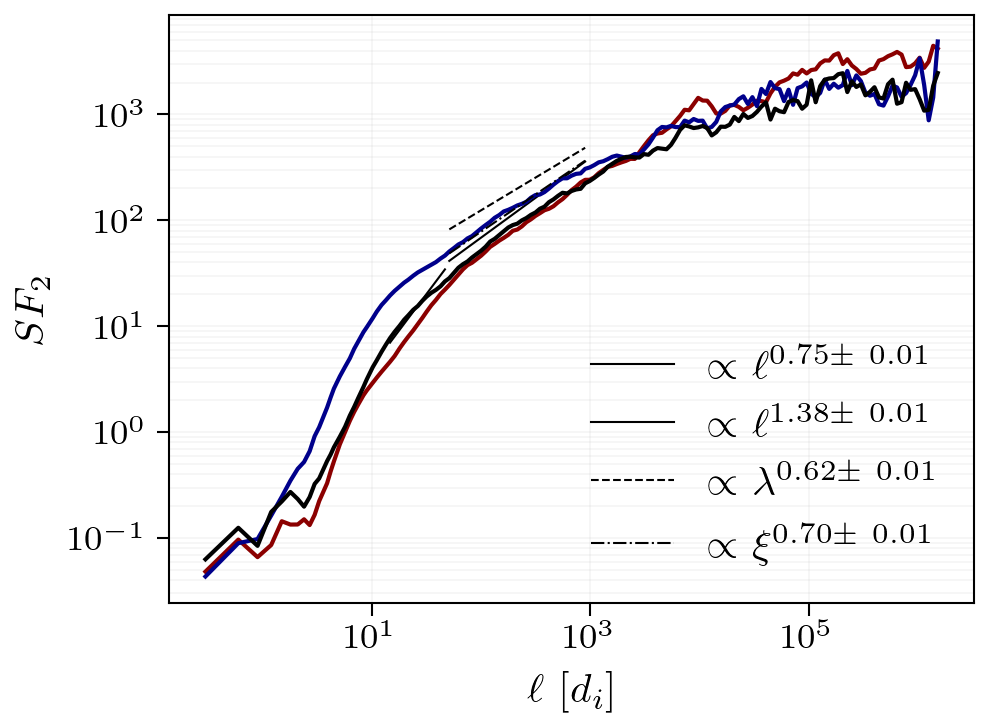

In [13]:
import matplotlib.pyplot as plt

x0, xf       = 50, 1000
x00, xf0     = 15, 50

norm_factor  = 1
inset_f_size = 10
labels       =  [r'$\ell$', r'$\lambda$', r'$\xi$', r'$Overall$']
lss          =  ['-','--','-.',':' ,'-:' ]
cols         = ['darkred', 'darkblue', 'k', 'orange']

ylabel, xlabel = r'$SF_{2}$', r"$\ell ~ [d_{i}]$"
fig, ax = figs.initializeFigure(ylabel, xlabel, '1col')
minor_tick_params, major_tick_params = figs.inset_axis_params(size=inset_f_size)

lines = [
    (ell_di, sf_ell_par[1]/norm_factor, '-', None),
    (ell_di, sf_ell_perp[1]/norm_factor, '-', '-.'),
    (ell_di, sf_Ell_perp[1]/norm_factor, '-', '--'),
   # (ell_di, sf_all[1]/norm_factor, '-', 'g--'),
]

for j,line in enumerate(lines):
    x, y, style, color = line
    plt.loglog(x, y,c=cols[j], ls=style, ms=0)#,label = labels[j])
    if j==0:
        for k in range(2):
            if k==0:
                fit, s, e, x, y = func.find_fit(x, y, x0, xf)
            else:
                fit, s, e, x, y = func.find_fit(x, y, x00, xf0)

            lab_name =r'$\propto \ $'+str(labels[j])+ r'$ ^{ {%.2f}  \pm \ {%.2f}  }$' % (round(fit[0][1], 2), round(np.sqrt(fit[1][1][1]), 2))
            plt.loglog(x[s:e], 1.5*fit[2],c='k', lw=0.5,ls=lss[j], ms=0, label=lab_name)
    else:
        fit, s, e, x, y = func.find_fit(x, y, x0, xf)
        lab_name =r'$\propto \ $'+str(labels[j])+ r'$ ^{ {%.2f}  \pm \ {%.2f}  }$' % (round(fit[0][1], 2), round(np.sqrt(fit[1][1][1]), 2))
        plt.loglog(x[s:e], 1.5*fit[2],c='k', lw=0.5,ls=lss[j], ms=0, label=lab_name)
#plt.axhline(y=1, ls='-.', lw=0.5)
plt.legend(loc=4, fontsize=10)
    # Axis grids
ax.xaxis.grid(True, "minor", linewidth=.05, ls='-');  
ax.yaxis.grid(True, "major", linewidth=.05, ls='-');
ax.yaxis.grid(True, "minor", linewidth=.05, ls='-');  
ax.xaxis.grid(True, "major", linewidth=.05, ls='-');    

# ax1.xaxis.grid(True, "minor", linewidth=.1, ls='-');  
# ax1.yaxis.grid(True, "major", linewidth=.1, ls='-');
# ax1.yaxis.grid(True, "minor", linewidth=.1, ls='-');  
# ax1.xaxis.grid(True, "major", linewidth=.1, ls='-'); 

# Plot 5 point Sf2

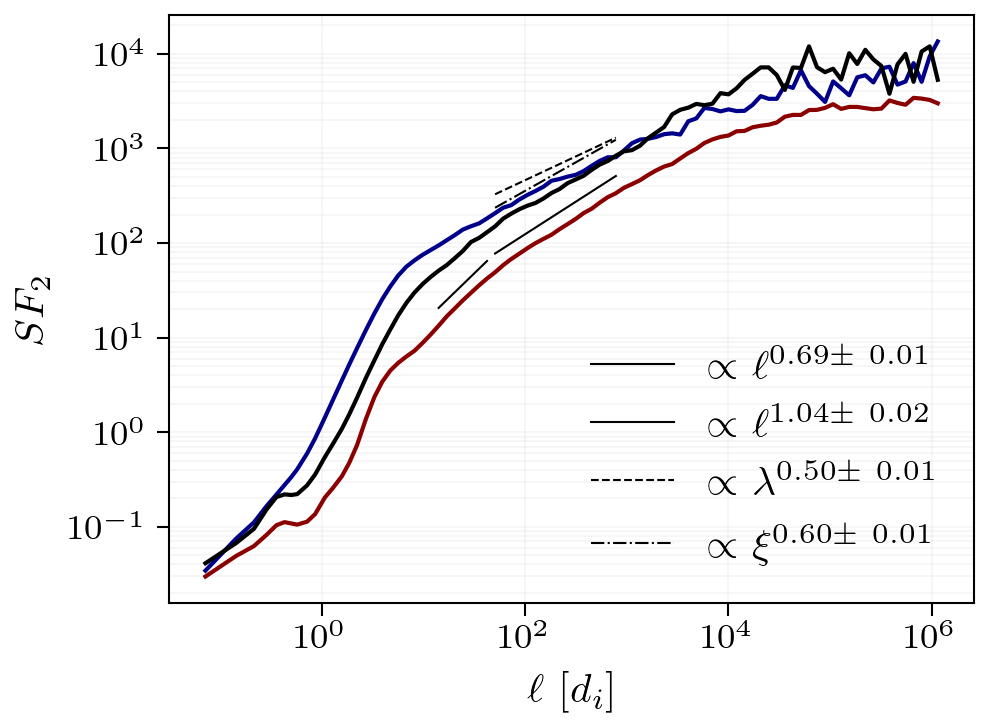

In [91]:
import matplotlib.pyplot as plt

x0, xf       = 50, 1000
x00, xf0     = 15, 50

norm_factor  = 1
inset_f_size = 10
labels       =  [r'$\ell$', r'$\lambda$', r'$\xi$', r'$Overall$']
lss          =  ['-','--','-.',':' ,'-:' ]
cols         = ['darkred', 'darkblue', 'k', 'orange']

ylabel, xlabel = r'$SF_{2}$', r"$\ell ~ [d_{i}]$"
fig, ax = figs.initializeFigure(ylabel, xlabel, '1col')
minor_tick_params, major_tick_params = figs.inset_axis_params(size=inset_f_size)

lines = [
    (ell_di, sf_ell_par[1]/norm_factor, '-', None),
    (ell_di, sf_ell_perp[1]/norm_factor, '-', '-.'),
    (ell_di, sf_Ell_perp[1]/norm_factor, '-', '--'),
   # (ell_di, sf_all[1]/norm_factor, '-', 'g--'),
]

for j,line in enumerate(lines):
    x, y, style, color = line
    plt.loglog(x, y,c=cols[j], ls=style, ms=0)#,label = labels[j])
    if j==0:
        for k in range(2):
            if k==0:
                fit, s, e, x, y = func.find_fit(x, y, x0, xf)
            else:
                fit, s, e, x, y = func.find_fit(x, y, x00, xf0)

            lab_name =r'$\propto \ $'+str(labels[j])+ r'$ ^{ {%.2f}  \pm \ {%.2f}  }$' % (round(fit[0][1], 2), round(np.sqrt(fit[1][1][1]), 2))
            plt.loglog(x[s:e], 1.5*fit[2],c='k', lw=0.5,ls=lss[j], ms=0, label=lab_name)
    else:
        fit, s, e, x, y = func.find_fit(x, y, x0, xf)
        lab_name =r'$\propto \ $'+str(labels[j])+ r'$ ^{ {%.2f}  \pm \ {%.2f}  }$' % (round(fit[0][1], 2), round(np.sqrt(fit[1][1][1]), 2))
        plt.loglog(x[s:e], 1.5*fit[2],c='k', lw=0.5,ls=lss[j], ms=0, label=lab_name)
#plt.axhline(y=1, ls='-.', lw=0.5)
plt.legend(loc=4, fontsize=10)
    # Axis grids
ax.xaxis.grid(True, "minor", linewidth=.05, ls='-');  
ax.yaxis.grid(True, "major", linewidth=.05, ls='-');
ax.yaxis.grid(True, "minor", linewidth=.05, ls='-');  
ax.xaxis.grid(True, "major", linewidth=.05, ls='-');    

# ax1.xaxis.grid(True, "minor", linewidth=.1, ls='-');  
# ax1.yaxis.grid(True, "major", linewidth=.1, ls='-');
# ax1.yaxis.grid(True, "minor", linewidth=.1, ls='-');  
# ax1.xaxis.grid(True, "major", linewidth=.1, ls='-'); 

In [ ]:
 a_{PSD} = - 1 -a_{sf2}

# This is how the 2-point structur function looks like

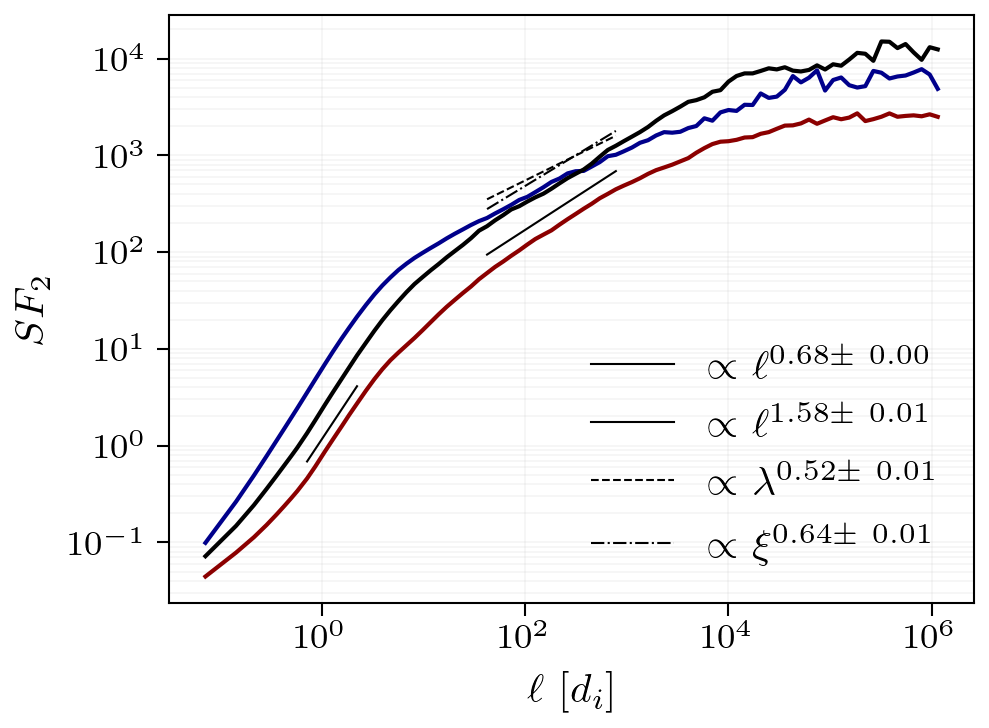

In [58]:
import matplotlib.pyplot as plt

x0, xf       = 40, 1000
x00, xf0     = 0.7, 3
norm_factor  = 1
inset_f_size = 10
labels       =  [r'$\ell$', r'$\lambda$', r'$\xi$', r'$Overall$']
lss          =  ['-','--','-.',':' ,'-:' ]
cols         = ['darkred', 'darkblue', 'k', 'orange']

ylabel, xlabel = r'$SF_{2}$', r"$\ell ~ [d_{i}]$"
fig, ax = figs.initializeFigure(ylabel, xlabel, '1col')
minor_tick_params, major_tick_params = figs.inset_axis_params(size=inset_f_size)

lines = [
    (ell_di, sf_ell_par[1]/norm_factor, '-', None),
    (ell_di, sf_ell_perp[1]/norm_factor, '-', '-.'),
    (ell_di, sf_Ell_perp[1]/norm_factor, '-', '--'),
   # (ell_di, sf_all[1]/norm_factor, '-', 'g--'),
]

for j,line in enumerate(lines):
    x, y, style, color = line
    plt.loglog(x, y,c=cols[j], ls=style, ms=0)#,label = labels[j])
    if j==0:
        for k in range(2):
            if k==0:
                fit, s, e, x, y = func.find_fit(x, y, x0, xf)
            else:
                fit, s, e, x, y = func.find_fit(x, y, x00, xf0)

            lab_name =r'$\propto \ $'+str(labels[j])+ r'$ ^{ {%.2f}  \pm \ {%.2f}  }$' % (round(fit[0][1], 2), round(np.sqrt(fit[1][1][1]), 2))
            plt.loglog(x[s:e], 1.5*fit[2],c='k', lw=0.5,ls=lss[j], ms=0, label=lab_name)
    else:
        fit, s, e, x, y = func.find_fit(x, y, x0, xf)
        lab_name =r'$\propto \ $'+str(labels[j])+ r'$ ^{ {%.2f}  \pm \ {%.2f}  }$' % (round(fit[0][1], 2), round(np.sqrt(fit[1][1][1]), 2))
        plt.loglog(x[s:e], 1.5*fit[2],c='k', lw=0.5,ls=lss[j], ms=0, label=lab_name)
#plt.axhline(y=1, ls='-.', lw=0.5)
plt.legend(loc=4, fontsize=10)
    # Axis grids
ax.xaxis.grid(True, "minor", linewidth=.05, ls='-');  
ax.yaxis.grid(True, "major", linewidth=.05, ls='-');
ax.yaxis.grid(True, "minor", linewidth=.05, ls='-');  
ax.xaxis.grid(True, "major", linewidth=.05, ls='-');    

# ax1.xaxis.grid(True, "minor", linewidth=.1, ls='-');  
# ax1.yaxis.grid(True, "major", linewidth=.1, ls='-');
# ax1.yaxis.grid(True, "minor", linewidth=.1, ls='-');  
# ax1.xaxis.grid(True, "major", linewidth=.1, ls='-'); 

In [ ]:
import numpy as np
import pandas as pd

def find_closest_values_in_arrays(arr_list, L_list, limited_window=False, xlims=None):
    """
    Find the closest target to a specified value in each of the arrays in `arr_list` by interpolating the values
    in `L_list`.

    Parameters
    ----------
    arr_list : list of arrays
        List of arrays of target values.
    L_list : list of arrays or array
        List of arrays or a single array of the independent variable values.
    limited_window : bool, optional
        If True, the results will only be returned if the ell value falls within the `xlims` range.
        Default is False.
    xlims : tuple, optional
        Tuple of lower and upper bounds for ell values. Only used if `limited_window` is True.
        Default is None.

    Returns
    -------
    result_df : pandas DataFrame
        DataFrame with columns for each array in `arr_list` and the corresponding ell value and target value.
        If a corresponding value is not found, the value will be set to NaN.

    """
    
        

    if type(L_list) != list:
        L_list = [L_list] * len(arr_list)
        
    indices = [np.where(arr > -1e10)[0].astype(int) for arr in arr_list]
    arr_list = [arr[idx] for arr, idx in zip(arr_list, indices)]
    L_list = [L[idx] for L, idx in zip(L_list, indices)]

    
        
    max_index = np.argmax([arr[0] for arr in arr_list])
    max_arr = arr_list[max_index]
    result_dict  = []
    for i in range(len(max_arr)):
        closest_indices = [np.argmin(np.abs(max_arr[i] - arr)) for j, arr in enumerate(arr_list)]
        closest_vals    = [arr[idx] for arr, idx in zip([arr for j, arr in enumerate(arr_list)], closest_indices)]
        ells = []
        targets = []
        for val, arr, L in zip(closest_vals, [arr for j, arr in enumerate(arr_list) ], L_list):
            idx = closest_indices[closest_vals.index(val)]
            if idx > 0 and idx < len(arr) - 1:
                ell = np.interp(val, [arr[idx - 1], arr[idx + 1]], [L[idx - 1], L[idx + 1]])
                if limited_window and (ell < xlims[0] or ell > xlims[1]):
                    continue
                ells.append(ell)
                target = np.interp(ell, L, arr)
                targets.append(target)
                
        final_dict = {}
        for jj in range(len(arr_list)):
            final_dict["ell_"+str(jj)]      = ells[jj] if jj < len(ells) else np.nan
            final_dict["target"+str(jj)]    = targets[jj] if jj < len(targets) else np.nan
        result_dict.append(final_dict)

    return pd.DataFrame(result_dict)


In [ ]:
### x =np.linspace(0, 10, 10000)

yvalues    = [sf_ell_perp[1], sf_Ell_perp[1],  sf_ell_par[1],]
#yvalues    = [f1(x), f2(x),  f3(x)]
xvalues    = ell_di
xlimits    = [1, 20]
limit_wind = False
results    = find_closest_values_in_arrays(yvalues, xvalues, limited_window=limit_wind, xlims=xlimits)

In [ ]:
plt.loglog(results['ell_0'], results['ell_2'])
plt.loglog(results['ell_0'], results['ell_1'])
plt.loglog(results['ell_1'], results['ell_2'])

In [638]:
x0,xf = 1, 60

func.find_fit(results['ell_0'], results['ell_1'], x0,xf)

((array([0.25908989, 0.97233403]),
  array([[ 0.00020358, -0.00017243],
         [-0.00017243,  0.00018627]]),
  array([ 1.87154911,  2.26373885,  2.63137045,  3.00798176,  3.40673376,
          3.74159584,  4.13755673,  4.82070332,  5.20548179,  5.61780585,
          6.37365326,  7.06040753,  7.85987542,  8.46902428,  9.17447064,
         10.34349807, 10.87955372, 12.40044771, 14.081029  , 14.90186333,
         16.31363478, 17.05799874, 19.81003982, 20.59517298, 24.12666234,
         26.58170267, 27.36999236, 30.99330953, 35.54423691, 37.76604908,
         40.97380734, 46.14094891, 47.27878051, 55.81533378, 59.78005066,
         65.85022004, 71.94038038, 80.97564434, 84.79889104])),
 4,
 43,
 array([3.54953560e-01, 3.62948525e-01, 5.68381974e-01, 7.93079165e-01,
        1.03153601e+00, 1.25447045e+00, 1.46445381e+00, 1.68043539e+00,
        1.90995474e+00, 2.10329569e+00, 2.33254727e+00, 2.72951340e+00,
        2.95382448e+00, 3.19471739e+00, 3.63759214e+00, 4.04128831e+00,
        4.

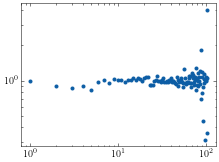

In [634]:
#plt.plot(df['targets_0'], df['targets_2'])
plt.loglog(results['target0']/ results['target2'])


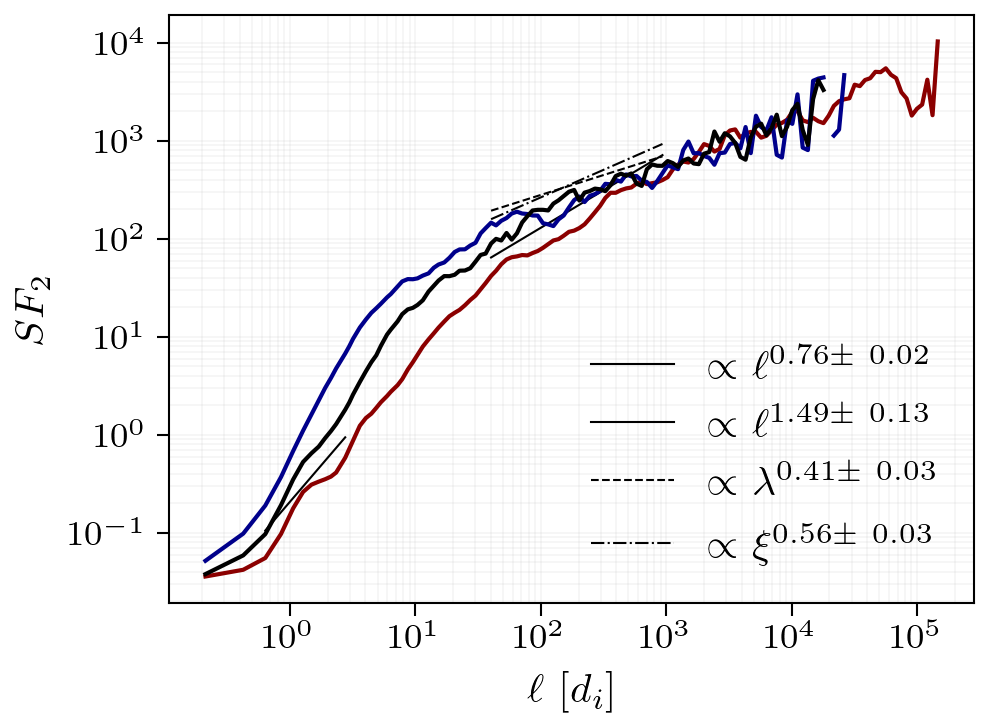

In [517]:
import matplotlib.pyplot as plt

x0, xf       = 40, 1000
x00, xf0     = 0.7, 3
norm_factor  = 1
inset_f_size = 10
labels       =  [r'$\ell$', r'$\lambda$', r'$\xi$', r'$Overall$']
lss          =  ['-','--','-.',':' ,'-:' ]
cols         = ['darkred', 'darkblue', 'k', 'orange']

ylabel, xlabel = r'$SF_{2}$', r"$\ell ~ [d_{i}]$"
fig, ax = figs.initializeFigure(ylabel, xlabel, '1col')
minor_tick_params, major_tick_params = figs.inset_axis_params(size=inset_f_size)

lines = [
    (ell_di, sf_ell_par[1]/norm_factor, '-', None),
    (ell_di, sf_ell_perp[1]/norm_factor, '-', '-.'),
    (ell_di, sf_Ell_perp[1]/norm_factor, '-', '--'),
   # (ell_di, sf_all[1]/norm_factor, '-', 'g--'),
]

for j,line in enumerate(lines):
    x, y, style, color = line
    plt.loglog(x, y,c=cols[j], ls=style, ms=0)#,label = labels[j])
    if j==0:
        for k in range(2):
            if k==0:
                fit, s, e, x, y = func.find_fit(x, y, x0, xf)
            else:
                fit, s, e, x, y = func.find_fit(x, y, x00, xf0)

            lab_name =r'$\propto \ $'+str(labels[j])+ r'$ ^{ {%.2f}  \pm \ {%.2f}  }$' % (round(fit[0][1], 2), round(np.sqrt(fit[1][1][1]), 2))
            plt.loglog(x[s:e], 1.5*fit[2],c='k', lw=0.5,ls=lss[j], ms=0, label=lab_name)
    else:
        fit, s, e, x, y = func.find_fit(x, y, x0, xf)
        lab_name =r'$\propto \ $'+str(labels[j])+ r'$ ^{ {%.2f}  \pm \ {%.2f}  }$' % (round(fit[0][1], 2), round(np.sqrt(fit[1][1][1]), 2))
        plt.loglog(x[s:e], 1.5*fit[2],c='k', lw=0.5,ls=lss[j], ms=0, label=lab_name)
#plt.axhline(y=1, ls='-.', lw=0.5)
plt.legend(loc=4, fontsize=10)
    # Axis grids
ax.xaxis.grid(True, "minor", linewidth=.05, ls='-');  
ax.yaxis.grid(True, "major", linewidth=.05, ls='-');
ax.yaxis.grid(True, "minor", linewidth=.05, ls='-');  
ax.xaxis.grid(True, "major", linewidth=.05, ls='-');    

# ax1.xaxis.grid(True, "minor", linewidth=.1, ls='-');  
# ax1.yaxis.grid(True, "major", linewidth=.1, ls='-');
# ax1.yaxis.grid(True, "minor", linewidth=.1, ls='-');  
# ax1.xaxis.grid(True, "major", linewidth=.1, ls='-'); 

In [ ]:
import numpy as np
from numpy import sin, cos, pi
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
   
   

    
x, y, z = pi*np.mgrid[-1:1:31j, -1:1:31j, -1:1:31j]
vol = fun(x, y, z)
iso_val=0.0
verts, faces = measure.marching_cubes(vol, iso_val, spacing=(0.1, 0.1, 0.1))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                cmap='Spectral', lw=1)
plt.show()

# tests

In [ ]:




def return_TRACE_SF2(flucts, wich_one, mean, std, wind, loglog):

    keys = list(flucts[which_one].keys())

    arrays =[]
    for j, key in enumerate(keys):
        d     = flucts[wich_one][key]
        arrays.append(np.hstack(np.array([d[key] for key in d.keys()]).T)**2)
        if j ==0:
            c     = flucts['l_di']
            arr_l = np.hstack(np.array([c[i]*np.ones(len(d[key])) for i, key in enumerate(d.keys())]).T)

    fluct_amplitude  = np.sum(arrays, axis=0)
    
    res = func.binned_quantity(arr_l,fluct_amplitude, mean, std, wind, loglog)
    
    return res

mean, std, wind, loglog   = 'mean', True, 10000, 1
which_ones                = list(flucts.keys())[0:3]


xvals =[]
yvals =[]
for which_one in which_ones:
    res = return_TRACE_SF2(flucts, which_one, mean, std, wind, loglog)
    xvals.append(res[0])
    yvals.append(res[1])

for i in range(len(xvals)):
    plt.loglog(xvals[i], yvals[i])